# Using ADQL to Search for Bright Stars Around the Open Cluster M67

In this section, we will investigate the bright stars in the open cluster M67. Our goal is to query the Gaia catalog to extract stars in M67 with a brightness (magnitude) less than 14.


In [17]:
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np

## Question 2.1

In this step, we query the Gaia catalog and crossmatch the data with 2MASS. We filter for stars with a magnitude less than 14 and extract key parameters from the Gaia catalog that determine the stars' brightness and position.


In [18]:
# Now perform the crossmatch with 2MASS using ADQL
adql_query = f"""
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.phot_g_mean_mag, 
       gaia.bp_rp, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, 
       tmass.j_m, tmass.ks_m, tmass.ph_qual, parallax
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
                 CIRCLE('ICRS', 132.825, 11.8, 1))
AND gaia.phot_g_mean_mag < 14
"""

# Execute the crossmatch query
job = Gaia.launch_job_async(adql_query)
xmatch_results = job.get_results()
xmatch_results.pprint(max_width=140)
print(xmatch_results.colnames)

INFO: Query finished. [astroquery.utils.tap.core]
    SOURCE_ID              ra                dec              parallax      phot_g_mean_mag ...  j_m    ks_m  ph_qual     parallax_2    
                          deg                deg                mas               mag       ...  mag    mag                  mas        
------------------ ------------------ ------------------ ------------------ --------------- ... ------ ------ ------- ------------------
598616293855857664  133.0426858357576 10.856399840955222  1.345385043402015       13.450183 ... 12.374 12.011     AAA  1.345385043402015
598616809251923712  133.0865605238264 10.882246707135543 1.4544763198057133       10.532544 ...  8.893  8.245     AAA 1.4544763198057133
598617187209051392 133.05531571492236 10.875582170748297 2.3010246059627697        11.31136 ...  10.52 10.256     AAA 2.3010246059627697
598617943123292416  133.0416850637062 10.928890718438762 1.2705602038194705       13.667251 ...  12.59 12.251     AAA 1.27056020

## Question 2.2

From the initial query, we retrieve 1018 stars that meet the magnitude criteria.


In [27]:
# Print the number of stars after filtering
print(f"Number of stars with G < 14: {len(xmatch_results)}")

Number of stars with G < 14: 1018


## Question 2.3

We apply the following criteria to refine the data:

- **ph_qual (photometric quality)**: This flag indicates the quality of photometry in the three infrared bands—J (1.25 µm), H (1.65 µm), and Ks (2.17 µm). We exclude stars where the photometry quality is not 'AAA', to remove poor-quality data.
- **Non-positive parallax**: We filter out stars with non-positive parallax values, as these are likely caused by statistical noise and do not represent a physical measurement.


In [28]:
# Remove stars with bad 2MASS photometry (ph_qual != 'AAA') 
quality_mask = (xmatch_results['ph_qual'] == 'AAA')


## Question 2.4

In [21]:
# Remove stars with non-positive parallax
quality_mask2 = (xmatch_results['parallax'] > 0)

## Question 2.5

Apply those two indicators as a filter to the data. As a result, 988 stars remain in the dataset

In [29]:
filtered_results = (quality_mask) & (quality_mask2)
filtered_results_final= xmatch_results[filtered_results]
print(filtered_results_final)

    SOURCE_ID              ra         ... ph_qual     parallax_2    
                          deg         ...                mas        
------------------ ------------------ ... ------- ------------------
598616293855857664  133.0426858357576 ...     AAA  1.345385043402015
598616809251923712  133.0865605238264 ...     AAA 1.4544763198057133
598617187209051392 133.05531571492236 ...     AAA 2.3010246059627697
598617943123292416  133.0416850637062 ...     AAA 1.2705602038194705
598620245225724928   133.232735716379 ...     AAA 14.503181255741397
598624437113819520 133.12697860742088 ...     AAA 1.5832017649406263
598625296107256320  133.2961441325748 ...     AAA 0.7774031255275894
598638662045573760 132.85974038194516 ...     AAA 0.7929417783955918
598638902563740672  132.8567342718141 ...     AAA  1.462564875189945
598639211801401088  132.7686761166671 ...     AAA  2.068649921457614
               ...                ... ...     ...                ...
605122550833920256  133.1290566809

In [31]:
# Print the number of stars after filtering
print(f"Number of stars remain: {len(filtered_results_final)}")

Number of stars remain: 988


## Question 2.6 and 2.7

We will now present the **Color-Magnitude Diagram (CMD)** of the stars, as well as the magnitude diagram from the 2MASS star catalog. 

First, we calculate:
- The **absolute magnitude** of the stars. Absolute magnitude is calculated by using the apparent magnitude and parallax from GAIA data.
- The **J-Ks magnitude**, which is the difference between the J-band and Ks-band magnitudes.


In [24]:
# Calculate absolute G magnitude (G_abs = G - 5 * log10(d) + 5)
distance_pc = 1000 / filtered_results_final['parallax']  # parallax is in milliarcseconds
G_abs = filtered_results_final['phot_g_mean_mag'] - 5 * np.log10(distance_pc) + 5

J_Ks_mag= filtered_results_final['j_m'] - filtered_results_final['ks_m']

Next, we plot the **Color-Magnitude Diagram (CMD)** and the **magnitude diagram** . After generating the plots, we save them with a resolution of 200 dots per inch.

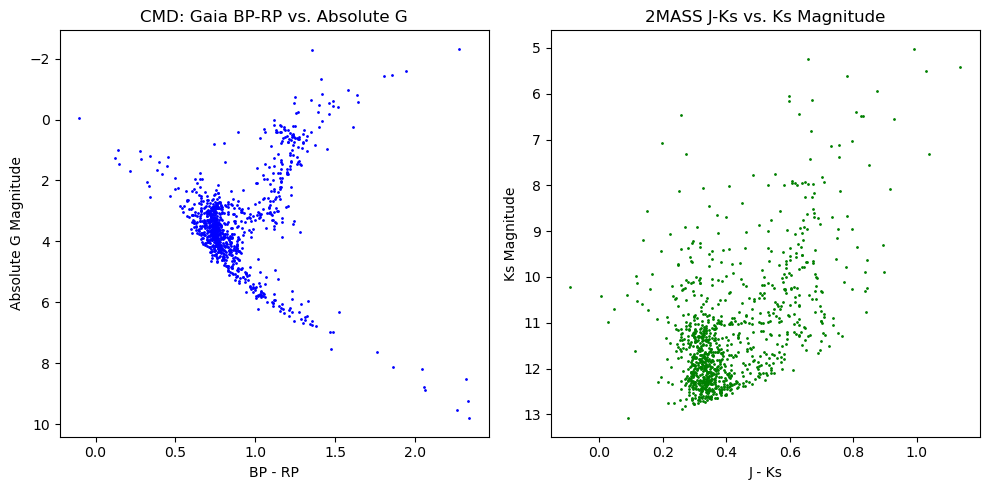

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# (a) Gaia BP-RP vs. absolute G magnitude (CMD)
axs[0].scatter(filtered_results_final['bp_rp'], G_abs, color='blue', s=1)
axs[0].invert_yaxis()  # Absolute magnitude decreases upwards
axs[0].set_xlabel('BP - RP')
axs[0].set_ylabel('Absolute G Magnitude')
axs[0].set_title('CMD: Gaia BP-RP vs. Absolute G')

# (b) 2MASS J-Ks vs. apparent Ks magnitude
axs[1].scatter(J_Ks_mag, filtered_results_final['ks_m'], color='green', s=1)
axs[1].invert_yaxis()  # Magnitude decreases upwards
axs[1].set_xlabel('J - Ks')
axs[1].set_ylabel('Ks Magnitude')
axs[1].set_title('2MASS J-Ks vs. Ks Magnitude')

# Save the figure
plt.tight_layout()
plt.savefig('figures/cmds_M67.png', dpi=200)
plt.show()


## Question 2.8: Analysis of Filtered Stars

After filtering, we retain **988 stars**, which is a sufficient sample size for observation, as they are both bright and have good photometric quality.

### Observations from the CMD Diagram

From the Color-Magnitude Diagram (CMD), we can conclude the following:

- The distribution of stars fits well within the diagram, indicating a healthy sample.
- The **J-Ks magnitude** reveals that these stars primarily have bright Ks magnitudes (located low on the y-axis) and relatively blue colors (lower J-Ks values). This suggests that they are minimally affected by dust and exhibit brightness in both optical and infrared wavelengths.

### Conclusion

Based on this information, we can conclude that the cluster is suitable for observations.
